In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
from scipy.optimize import curve_fit
from pathlib import Path
from ndlattice import mdlattice, second_excitation_energies, second_excitation_energies_spins
from matrixensembles import GOEsampler, MatrixStats, Betasampler, LatticeSampler, PalHuseSelector, OganesyanHuseSampler
from studies import ManyBodyLevels

output_dir = Path('../out/manybody/')

def paramstring(params, type='file'):
	if type == 'plot':
		return " ".join([f"{k}={v}" for k, v in params.items()])
	elif type == 'file':
		return "-".join([f"{k}{v}" for k, v in params.items()])
	elif type=='metadata':
		metadata = {}
		for k, v in params.items():
			metadata[k] = str(v)
		return metadata
	else:
		raise ValueError(f"Unknown type {type}")

def poissonweights(heights, norm=1):
	sigma = np.sqrt(heights/norm)
	sigma[sigma==0] = 1/norm
	return 1/sigma

# set default plot size to 720p
# plt.rcParams['figure.figsize'] = [1280/96, 720/96]
plt.rcParams['pgf.texsystem'] = 'lualatex'

In [8]:
d, n, w0 = 1, 14, 100
W, t = 5, 1
K = 0
TYPE='spins'
matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
matrixstats.collect(10**5)

100%|██████████| 29/29 [00:52<00:00,  1.82s/it]


In [ ]:
study = ManyBodyLevels(n_excitations=None)
manybody = study(matrixstats)

r=0.49626003417121367


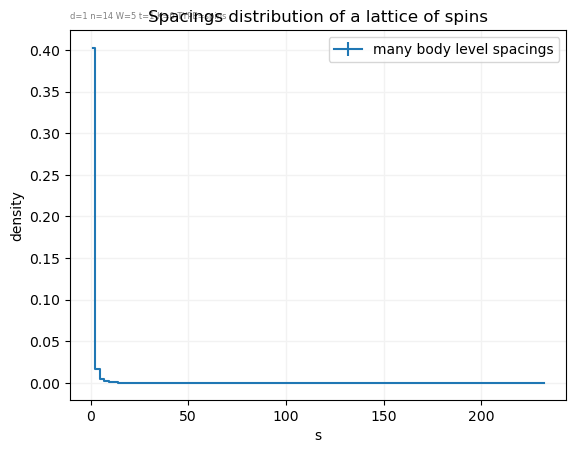

In [9]:
heights, borders = np.histogram(matrixstats.s().flatten(), bins=100)
norm = np.sum(heights) * np.diff(borders)[0]
heights = heights / norm
weights = poissonweights(heights, norm=norm)
centers = borders[:-1] + np.diff(borders) / 2

plt.xlabel(r"s")
plt.ylabel("density")

plt.errorbar(
    centers,
    heights,
    yerr = 1/weights,
    marker = '.',
    markersize = 0,
    drawstyle = 'steps-mid',
    label = "many body level spacings"
)

# add a grid of very light gray color
plt.grid(color='0.95', linestyle='-', linewidth=1)
plt.legend()
plt.title(f"Spacings distribution of a lattice of {TYPE}")
params = dict(d=d, n=n, W=W, t=t, K=K, TYPE=TYPE)
plt.text(0, 1.05, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')

# plt.savefig(output_dir / f'fit_{paramstring(params, "file")}.png')
# plt.savefig(output_dir / f'fit_{paramstring(params, "file")}.pgf')
print(f"r={np.mean(matrixstats.d2correlations().flatten())}")
plt.show()

In [24]:
matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
matrixstats.collect(n_realizations=2)
r = matrixstats.d2correlations()
print(r)

100%|██████████| 2/2 [00:52<00:00, 26.05s/it]

[0.26320111 0.67724841 0.41009176 ... 0.2807859  0.31248416 0.17696364]


In [36]:
d, n, w0 = 1, 16, 0
W, t = 3, 1
TYPE='spins'
study = ManyBodyLevels(n_excitations=None)

def correlation_transition(corr_W, n):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		matrixstats = MatrixStats(OganesyanHuseSampler(n, W))
		matrixstats.collect(n_realizations=50)
		r = matrixstats.d2correlations()
		r_avg = np.mean(r, axis=1) # average over disorder and states
		corr_r[i] = np.mean(r_avg)
		corr_err[i] = np.std(r_avg) / np.sqrt(len(r_avg))
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate([8, 10, 12, 14, 16]):
	corr_W = np.arange(2, 11)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, L)
	correlation_results[L] = (corr_W, corr_r, corr_err)

100%|██████████| 50/50 [20:54<00:00, 25.09s/it]


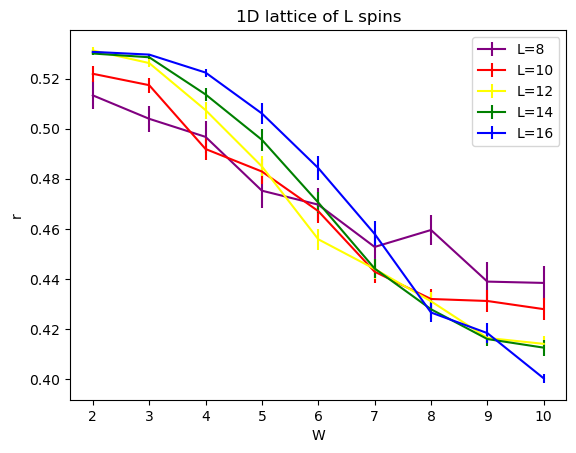

In [45]:
c = iter(["purple", "red", "yellow", "green", "blue"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))
plt.xlabel("W")
plt.ylabel("r")
plt.title("1D lattice of L spins")
plt.legend()
odir = output_dir / "spins"
odir.mkdir(parents=True, exist_ok=True)
plt.savefig(odir / f"correlation_transition.png", dpi=300)
plt.savefig(odir / f"correlation_transition.pdf")